In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    make_scorer
)
from sklearn.base import clone
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from settings import one_hot

In [52]:
df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFeature Information:")
np.random.seed(42)


Dataset Shape: (430, 75)

Feature Information:


In [53]:
def preprocess_data(df, selected_features, log_transform_features=None, one_hot_encode=False):
    X = df[selected_features].copy()
    
    # Store original MgFe for potential restoration
    original_mgfe = X['MgFe'].copy() if 'MgFe' in X.columns else None
    
    if one_hot_encode and 'MgFe' in X.columns:
        # Define bins and labels
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, np.inf]
        mgfe_labels = ['MgFe_0.0', 'MgFe_0.1', 'MgFe_0.2', 'MgFe_0.3', 'MgFe_0.4']
        
        # Create binned version
        X['MgFe_binned'] = pd.cut(X['MgFe'], 
                                 bins=bins, 
                                 labels=mgfe_labels, 
                                 include_lowest=True, 
                                 right=False)
        
        # One-hot encode the binned column
        mgfe_encoded = pd.get_dummies(X['MgFe_binned'], prefix='', prefix_sep='')
        
        # Drop original and binned MgFe columns
        X = X.drop(['MgFe', 'MgFe_binned'], axis=1)
        
        # Add encoded columns
        X = pd.concat([X, mgfe_encoded], axis=1)
    
    # Log transform features
    if log_transform_features is None:
        log_transform_features = {
            'age_mean_mass': False,
            'velDisp_ppxf_res': False,
            '[M/H]_mean_mass': False
        }

    for feature, do_log in log_transform_features.items():
        if do_log and feature in X.columns:
            X[feature] = np.log10(X[feature] + 1e-10)
    
    return X, X.columns.tolist(), original_mgfe

def restore_original_mgfe(df, original_mgfe, mgfe_labels=None):
    if mgfe_labels is None:
        mgfe_labels = ['MgFe_0.0', 'MgFe_0.1', 'MgFe_0.2', 'MgFe_0.3', 'MgFe_0.4']
    
    # Remove one-hot columns
    df = df.drop(columns=[col for col in df.columns if col in mgfe_labels])
    
    # Restore original MgFe
    if original_mgfe is not None:
        df['MgFe'] = original_mgfe
    
    return df

In [54]:
def plot_feature_importance(model, feature_names):
    """Plot feature importances for models that support them."""
    if hasattr(model.named_steps['regressor'], 'feature_importances_'):
        importance = model.named_steps['regressor'].feature_importances_
        indices = np.argsort(importance)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(range(len(importance)), importance[indices])
        plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
        plt.tight_layout()
        plt.show()

        # Print numerical values
        for i in indices:
            print(f"{feature_names[i]}: {importance[i]:.4f}")
    else:
        print("This model doesn't support feature importances")

def plot_regression_results(y_true, y_pred, model_name):
    """Plot regression results with metrics."""
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_true, y_pred, alpha=0.5)

    # Diagonal line for perfect predictions
    min_val, max_val = 0, 1
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    ax.set_title(f'{model_name} Regression Results')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')

    text = (f'R² = {r2:.3f}\n'
            f'RMSE = {rmse:.3f}\n'
            f'MAE = {mae:.3f}')
    ax.text(0.05, 0.95, text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    return fig

In [55]:
def comprehensive_regression_analysis(X, y, test_size=0.2, random_state=42, log_transform_features=None, n_iter = 1000):
    # Split data
    output_path = '../data/feature_importances'
    os.makedirs(output_path, exist_ok=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    results = {}

    for name, model_info in models.items():
        print(f"\nEvaluating {name}...")
        
        # Create and fit scaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        if model_info['params']:
            if name == 'XGBoost':
                random_search = RandomizedSearchCV(
                    estimator=XGBRegressor(
                        objective='reg:squarederror',
                        enable_categorical=False,
                        random_state=random_state
                    ),
                    param_distributions=model_info['params'],
                    n_iter=n_iter,
                    cv=5,
                    scoring='neg_mean_squared_error',
                    random_state=random_state,
                    n_jobs=-1,
                    verbose=1
                )
            elif name == 'Random Forest':
                random_search = RandomizedSearchCV(
                    estimator=RandomForestRegressor(random_state=random_state),
                    param_distributions=model_info['params'],
                    n_iter=n_iter,
                    cv=5,
                    scoring='neg_mean_squared_error',
                    random_state=random_state,
                    n_jobs=-1,
                    verbose=1
                )
            
            random_search.fit(X_train_scaled, y_train)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            
            y_pred = best_model.predict(X_test_scaled)
            
            results[name] = {
                'best_params': best_params,
                'y_pred': y_pred,
                'r2_score': r2_score(y_test, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                'mae': mean_absolute_error(y_test, y_pred)
            }
            
            print("Best Parameters:", best_params)
            
            if hasattr(best_model, 'feature_importances_'):
                importance = best_model.feature_importances_
                indices = np.argsort(importance)[::-1]
                
                plt.figure(figsize=(10, 6))
                plt.title("Feature Importances")
                plt.bar(range(len(importance)), importance[indices])
                plt.xticks(range(len(importance)), [X.columns[i] for i in indices], rotation=45)
                plt.tight_layout()
                plt.show()
                
                for i in indices:
                    print(f"{X.columns[i]}: {importance[i]:.4f}")
                
                df = pd.DataFrame([importance], columns=feature_names)
                df.to_csv(output_path+"/"+name+'.csv', index=False)
        else:
            # For models without parameters (like Linear Regression)
            model = clone(model_info['model'])
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            
            results[name] = {
                'y_pred': y_pred,
                'r2_score': r2_score(y_test, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                'mae': mean_absolute_error(y_test, y_pred)
            }
        
        # Visualization
        plot_regression_results(y_test, results[name]['y_pred'], name)
        plt.show()
    
    return results

In [56]:
models = {
    'XGBoost': {
        'model': None,
        'params': {
            'n_estimators': randint(100, 1000),    
            'max_depth': randint(3, 15),           
            'learning_rate': uniform(0.01, 0.49),  # Changed to ensure max is 0.5
            'subsample': uniform(0.3, 0.7),        # Changed to ensure max is 1.0
            'min_child_weight': randint(1, 7)
        }
    },
    'Random Forest': {
        'model': None,
        'params': {
            'n_estimators': randint(100, 1000),
            'max_depth': randint(10, 100),
            'min_samples_split': randint(2, 10),
            'max_features': uniform(0.1, 0.8),     # Changed to ensure max is < 1.0
            'max_samples': uniform(0.6, 0.4)       # Changed to ensure max is 1.0
        }
    },
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    }
}

models = {
    'XGBoost': {
        'model': None,
        'params': {
            'n_estimators': randint(100, 1000),    
            'max_depth': randint(3, 15),           
            'learning_rate': uniform(0.01, 0.49),  # Changed to ensure max is 0.5
            'subsample': uniform(0.3, 0.7),        # Changed to ensure max is 1.0
            'min_child_weight': randint(1, 7)
        }
    },
}


Evaluating XGBoost...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Parameters: {'learning_rate': 0.03354887285654653, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 199, 'subsample': 0.33171280684043114}


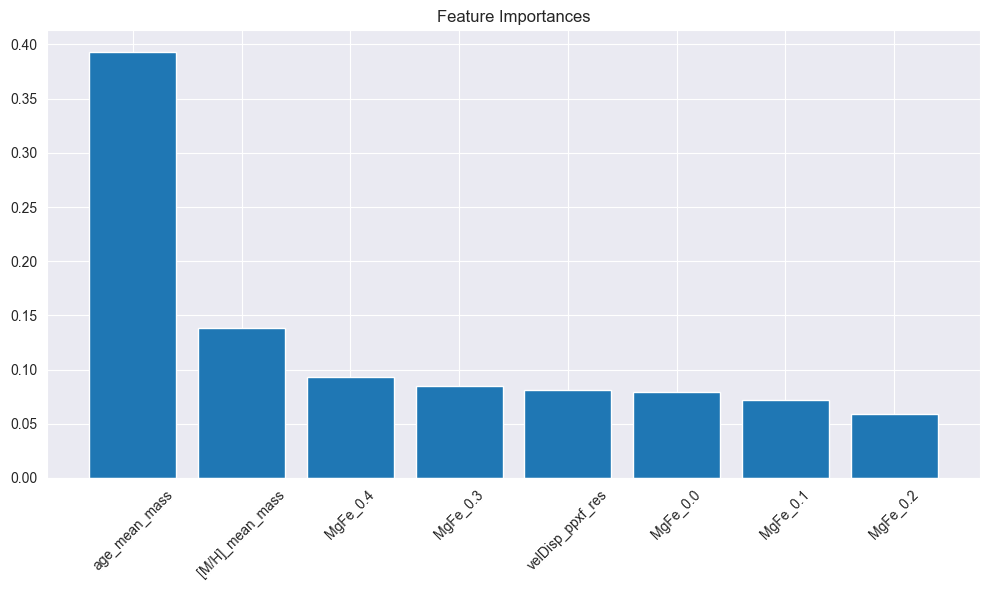

age_mean_mass: 0.3933
[M/H]_mean_mass: 0.1379
MgFe_0.4: 0.0929
MgFe_0.3: 0.0846
velDisp_ppxf_res: 0.0810
MgFe_0.0: 0.0790
MgFe_0.1: 0.0722
MgFe_0.2: 0.0591


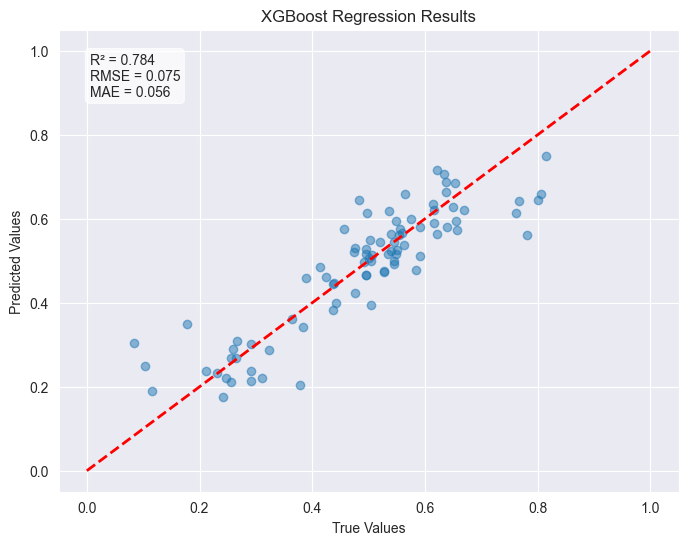


--- Regression Model Comparison ---

XGBoost:
R² Score: 0.7842
RMSE: 0.0755
MAE: 0.0565
Best Hyperparameters: {'learning_rate': 0.03354887285654653, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 199, 'subsample': 0.33171280684043114}


In [57]:
# Select features for the analysis
selected_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']

# Configure log transformations
log_transform_config = {
    'age_mean_mass': True,
    'velDisp_ppxf_res': False,
    'MgFe': False,
    '[M/H]_mean_mass': False
}





one_hot_encode = one_hot  # change in settings.py




# Preprocess data
X, feature_names, original_mgfe = preprocess_data(
    df, 
    selected_features, 
    log_transform_features=log_transform_config,
    one_hot_encode=one_hot_encode
)
y = df['DoR'].values

# Run the analysis
results = comprehensive_regression_analysis(
    X,
    y,
    test_size=0.2,
    random_state=42,
    log_transform_features=log_transform_config,
    n_iter=500
)

# Print final results comparison
print("\n--- Regression Model Comparison ---")
for name, result in results.items():
    print(f"\n{name}:")
    print(f"R² Score: {result['r2_score']:.4f}")
    print(f"RMSE: {result['rmse']:.4f}")
    print(f"MAE: {result['mae']:.4f}")
    if 'best_params' in result:
        print("Best Hyperparameters:", result['best_params'])
        
if one_hot_encode:
    X = restore_original_mgfe(X, original_mgfe)